In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm


### Import both GMD and weekly estimated cases

In [2]:
all_state_mob_data = pd.read_csv("data/all_state_mob_data.csv")
weekly_est_cases_deaths = pd.read_csv("data/weekly_est_cases_deaths.csv")

all_state_mob_data['date'] = pd.to_datetime(all_state_mob_data['date'])
weekly_est_cases_deaths['date'] = pd.to_datetime(weekly_est_cases_deaths['date'])

In [3]:
weekly_est_cases_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 25 columns):
state                       2205 non-null object
date                        2205 non-null datetime64[ns]
new_cases_jhu               2205 non-null int64
new_deaths_jhu              2205 non-null int64
Excess Lower Estimate       2103 non-null float64
Excess Higher Estimate      2103 non-null float64
mid_point_xs_deaths         2103 non-null float64
corr_new_deaths             2205 non-null float64
est_inf                     2103 non-null float64
pro_chg_est_inf             2068 non-null float64
mobile_infectious           2086 non-null float64
phi                         2086 non-null float64
population                  2205 non-null int64
est_inf_per_100k            2103 non-null float64
new_cases_per_100k          2205 non-null float64
state_id                    2205 non-null object
rho                         2205 non-null float64
weekly_exposures            2154 non-null fl

### Select only the change from baseline data from the Google Mobility Data and then sum by week

In [4]:
all_state_mob_data['date'] = pd.to_datetime(all_state_mob_data['date'])
mob_data = all_state_mob_data.iloc[:,0:8].copy()
name_change_dict = {
    'retail_and_recreation_percent_change_from_baseline':'retail_weekly_change',
    'grocery_and_pharmacy_percent_change_from_baseline':'grocery_weekly_change',
    'parks_percent_change_from_baseline':'parks_weekly_change',
    'transit_stations_percent_change_from_baseline':'transit_weekly_change',
    'workplaces_percent_change_from_baseline':'work_weekly_change',
    'residential_percent_change_from_baseline':'home_weekly_change'
}
weekly_mobility_data = mob_data.groupby('sub_region_1').resample('W-SAT', on='date').sum()
weekly_mobility_data.rename(columns=name_change_dict, inplace=True)
weekly_mobility_data.reset_index(inplace=True)

In [5]:
weekly_mobility_data.head()

,sub_region_1,date,retail_weekly_change,grocery_weekly_change,parks_weekly_change,transit_weekly_change,work_weekly_change,home_weekly_change
0,Alabama,2020-02-15,5.0,2.0,39.0,7.0,2.0,-1.0
1,Alabama,2020-02-22,4.0,-6.0,38.0,34.0,-9.0,9.0
2,Alabama,2020-02-29,63.0,29.0,134.0,75.0,7.0,-4.0
3,Alabama,2020-03-07,79.0,47.0,168.0,65.0,19.0,-4.0
4,Alabama,2020-03-14,59.0,114.0,272.0,67.0,10.0,-4.0


### Select only state, date, estimated infections per 100k population, and phi from esimated infections data by state

In [43]:
input_state = 'California'

In [44]:
# limit the date range to a 'no-earlier-than' date (filter is applied directly below and for the GMD specified state/date range filter)
date_selector = pd.to_datetime('2020-02-28')

In [45]:
weekly_for_state = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == input_state) & (weekly_est_cases_deaths['date'] > date_selector)].copy()
weekly_for_state = weekly_for_state[['state','date','est_inf_per_100k','phi']]

### Select GMD for the specified state

In [46]:
weekly_mobility_data_for_state = weekly_mobility_data[(weekly_mobility_data['sub_region_1'] == input_state)& (weekly_mobility_data['date'] > date_selector)].copy()
del weekly_mobility_data_for_state['sub_region_1']

### Merge the two data sets

In [47]:
df_gmd_and_infections = pd.merge(weekly_for_state, weekly_mobility_data_for_state, how='inner', left_on=['date'], right_on=['date'])

In [48]:
cols_order_change = ['date',
 'retail_weekly_change',
 'grocery_weekly_change',
 'parks_weekly_change',
 'transit_weekly_change',
 'work_weekly_change',
 'home_weekly_change',
'phi',
'est_inf_per_100k',]

In [49]:
df_gmd_and_infections = df_gmd_and_infections[cols_order_change]
df_gmd_and_infections.dropna(inplace=True)

## Generate the X training set for the linear regression model

In [50]:
X = df_gmd_and_infections[[
 'retail_weekly_change',
 'grocery_weekly_change',
 'parks_weekly_change',
 'transit_weekly_change',
 'work_weekly_change',
 'home_weekly_change',
'phi']]
y = df_gmd_and_infections['est_inf_per_100k']

#### Manual method for generating a scaled X set - ignore because now I've setup the pipeline

In [51]:
df_gmd_and_infections_no_date = df_gmd_and_infections.copy()
del df_gmd_and_infections_no_date['date']

In [52]:
df_gmd_and_infections_no_date.head(3)

,retail_weekly_change,grocery_weekly_change,parks_weekly_change,transit_weekly_change,work_weekly_change,home_weekly_change,phi,est_inf_per_100k
0,30.0,40.0,67.0,-11.0,16.0,-1.0,0.000007,30.145102
1,-12.0,89.0,-47.0,-97.0,-24.0,21.0,0.000301,58.060515
2,-200.0,34.0,-148.0,-263.0,-220.0,103.0,0.000581,143.661874


### Manual multivariate linear regression
modified from <html>https://medium.com/we-are-orb/multivariate-linear-regression-in-python-without-scikit-learn-7091b1d45905</html>

In [53]:
# normalize the features using mean normalization
df_gmd_and_infections_no_date_normalized = (df_gmd_and_infections_no_date - df_gmd_and_infections_no_date.mean())/df_gmd_and_infections_no_date.std()
df_gmd_and_infections_no_date_normalized.head(3)

,retail_weekly_change,grocery_weekly_change,parks_weekly_change,transit_weekly_change,work_weekly_change,home_weekly_change,phi,est_inf_per_100k
0,3.239396,2.391153,1.171323,4.278345,3.959665,-3.097598,-1.816440,-1.555164
1,2.699293,3.511598,0.174470,2.952899,3.359499,-2.355523,-1.634534,-1.403799
2,0.281687,2.253956,-0.708706,0.394478,0.418687,0.410390,-1.461820,-0.939643


In [54]:
#setting the matrixes
X = df_gmd_and_infections_no_date_normalized.iloc[:,0:7]
ones = np.ones([X.shape[0],1])
X = np.concatenate((ones,X),axis=1)

y = df_gmd_and_infections_no_date_normalized.iloc[:,7:8].values #.values converts it from pandas.core.frame.DataFrame to numpy.ndarray
theta = np.zeros([1,8])

#set hyper parameters
alpha = .3
iters = 1000

In [55]:
def computeCost(X,y,theta):
    tobesummed = np.power(((X @ theta.T)-y),2)
    return np.sum(tobesummed)/(2 * len(X))

In [56]:
def gradientDescent(X,y,theta,iters,alpha):
    cost = np.zeros(iters)
    for i in range(iters):
        theta = theta - (alpha/len(X)) * np.sum(X * (X @ theta.T - y), axis=0)
        cost[i] = computeCost(X, y, theta)
    
    return theta,cost

#running the gd and cost function
g,cost = gradientDescent(X,y,theta,iters,alpha)
print(g)

finalCost = computeCost(X,y,g)
print(finalCost)

[[-5.23390854e-16  3.24258447e-01  2.01659934e-01 -5.93941526e-03
  -4.44297081e-01  1.80880255e-01  2.18050507e-01  8.69584019e-01]]
0.08969191062659856


Text(0.5, 1.0, 'Error vs. Training Epoch')

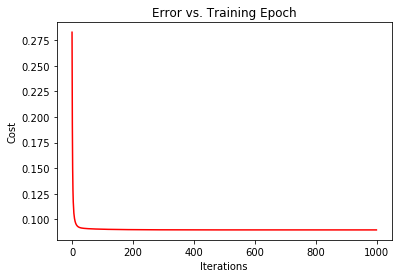

In [57]:
fig, ax = plt.subplots()  
ax.plot(np.arange(iters), cost, 'r')  
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Epoch')  

In [58]:
thetas_lst = g.tolist()[0]
thetas_lst.insert(0,input_state)
thetas_lst

['California',
 -5.233908544661449e-16,
 0.3242584467306371,
 0.2016599339450054,
 -0.005939415262872657,
 -0.4442970809219662,
 0.1808802550527583,
 0.21805050666845335,
 0.8695840189519322]

In [59]:
columns=['state','y_intercept', 'theta_retail', 'theta_grocery',' theta_parks', 'theta_transit','theta_work','theta_home','theta_phi']
theta_df = pd.DataFrame(columns=columns)

In [60]:
thetas_dict = dict(zip(columns, thetas_lst))
thetas_dict

{'state': 'California',
 'y_intercept': -5.233908544661449e-16,
 'theta_retail': 0.3242584467306371,
 'theta_grocery': 0.2016599339450054,
 ' theta_parks': -0.005939415262872657,
 'theta_transit': -0.4442970809219662,
 'theta_work': 0.1808802550527583,
 'theta_home': 0.21805050666845335,
 'theta_phi': 0.8695840189519322}

In [61]:
theta_df = theta_df.append(thetas_dict, ignore_index=True)

In [62]:
df_gmd_and_infections_no_date.head(3)

,retail_weekly_change,grocery_weekly_change,parks_weekly_change,transit_weekly_change,work_weekly_change,home_weekly_change,phi,est_inf_per_100k
0,30.0,40.0,67.0,-11.0,16.0,-1.0,0.000007,30.145102
1,-12.0,89.0,-47.0,-97.0,-24.0,21.0,0.000301,58.060515
2,-200.0,34.0,-148.0,-263.0,-220.0,103.0,0.000581,143.661874


In [63]:
input_state

'California'

In [64]:
columns = ['state','retail_weekly_change','grocery_weekly_change','parks_weekly_change','transit_weekly_change',
           'work_weekly_change','home_weekly_change','phi','est_inf_per_100k']

In [65]:
model_data_means_series = df_gmd_and_infections_no_date.mean(axis=0)
model_data_means_lst = model_data_means_series.tolist()
model_data_means_lst.insert(0,input_state)
model_data_means_dic = dict(zip(columns,model_data_means_lst))
df_model_means = pd.DataFrame(columns=columns)
df_model_means.append(model_data_means_dic, ignore_index=True)

,state,retail_weekly_change,grocery_weekly_change,parks_weekly_change,transit_weekly_change,work_weekly_change,home_weekly_change,phi,est_inf_per_100k
0,California,-221.904762,-64.571429,-66.952381,-288.595238,-247.904762,90.833333,0.002943,316.954603


In [66]:
model_data_std_series = df_gmd_and_infections_no_date.std(axis=0)
model_data_std_lst = model_data_std_series.tolist()
model_data_std_lst.insert(0,input_state)
model_data_std_dic = dict(zip(columns,model_data_std_lst))
df_model_std = pd.DataFrame(columns=columns)
df_model_std.append(model_data_std_dic, ignore_index=True)

,state,retail_weekly_change,grocery_weekly_change,parks_weekly_change,transit_weekly_change,work_weekly_change,home_weekly_change,phi,est_inf_per_100k
0,California,77.76287,43.732637,114.359927,64.883783,66.648261,29.646632,0.001616,184.423964


In [67]:
# DF of the input features (GMD 0-6 and phi)
test_df = pd.DataFrame(X[:,1:8])

In [68]:
theta_df.iloc[0,1:9]

y_intercept     -5.23391e-16
theta_retail        0.324258
theta_grocery        0.20166
 theta_parks     -0.00593942
theta_transit      -0.444297
theta_work           0.18088
theta_home          0.218051
theta_phi           0.869584
Name: 0, dtype: object

In [69]:
ones = np.ones([test_df.shape[0],1])
test_df = np.concatenate((ones,test_df),axis=1)

In [70]:
test_df = pd.DataFrame(test_df)
test_df.head(2)

,0,1,2,3,4,5,6,7
0,1.0,3.239396,2.391153,1.171323,4.278345,3.959665,-3.097598,-1.816440
1,1.0,2.699293,3.511598,0.174470,2.952899,3.359499,-2.355523,-1.634534


In [71]:
test1 = theta_df.iloc[0,1:9].to_numpy()

In [72]:
type(test1)

numpy.ndarray

In [73]:
print(test_df.shape)
print(test1.shape)

(42, 8)
(8,)


In [74]:
hyp_df = pd.DataFrame(test_df.dot(test1))

In [75]:
hyp_df.head(2)

,0
0,-1.91397
1,-1.0569


In [76]:
hyp_df['y'] = y

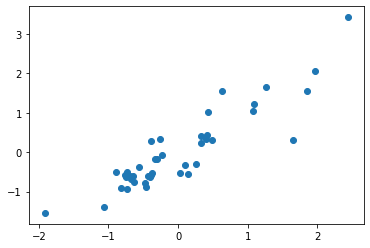

In [77]:
plt.scatter(hyp_df.iloc[:,0], hyp_df.iloc[0:,1])

<Figure size 432x288 with 0 Axes>

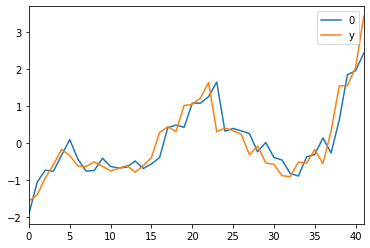

In [78]:
plt.figure(); hyp_df.plot(); plt.legend(loc='best')

In [79]:
# df_gmd_and_infections_no_date_normalized = (df_gmd_and_infections_no_date - df_gmd_and_infections_no_date.mean())/df_gmd_and_infections_no_date.std()